## Ultimate Challenge Part 3

Tamara Monge

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import json
from datetime import datetime
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all" 

from time import time
from datetime import datetime, date, timedelta
import calendar

# Statistics
from statsmodels.tsa.seasonal import seasonal_decompose

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

# supervised learning
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

/Users/Tami/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
# Read in the json file 
with open('ultimate_data_challenge.json', 'r') as json_file:
    json_data = json.load(json_file)

# Convert json data to a dataframe 
df = pd.DataFrame(json_data)

# Examine the dataframe
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


** Wrangling**

In [3]:
# Turn signup_date and last_trip_date into datetime objects
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

# Create categorical feature indicating 'DOW-of-signup' 
df['signup_dow'] = np.zeros(df.shape[0]) #initialize
df['signup_dow'] = [calendar.day_name[(df['signup_date'].iloc[i]).weekday()] for i in range(df.shape[0])]

# Set signup_date as index
df.set_index(['signup_date'], inplace=True)

In [4]:
# Deal with Missing Data
# Impute missing rating values with their averages
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace=True)
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace=True)

# Impute missing phone values with 'unknown'
df['phone'].fillna('unknown', inplace=True)

** Feature Engineering**

In [5]:
# Create variable cutoff identifying the preceding 30 days.
cutoff = df['last_trip_date'].max()-timedelta(30)

# Retained users are those who have taken a trip after cutoff.
df['retained'] = df['last_trip_date'] >= cutoff

In [6]:
cutoff

Timestamp('2014-06-01 00:00:00')

** Exploratory Analysis**

In [7]:
df.describe()
df['retained'].describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.445753,0.564977,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.500000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.700000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


count     50000
unique        2
top       False
freq      31196
Name: retained, dtype: object

In [8]:
df['retained'].sum()/df['retained'].count()

0.37608000000000003

In [9]:
df['retained'].sum()

18804

- **38% of the observed users were retained in their 6th month on the system.**
- Average trip distance in first 30 days is 5.8 miles.
- Average rating by driver is 4.8.
- Average rating of driver is 4.6.
- Average surge multiplier is 1.1.
- Average percentage of trips taken with surge multiplier > 1 is 8.8.
- Average number of trips taken in first 30 days is 2.3
- Average percentage of trips occuring during a weekday is 61%.

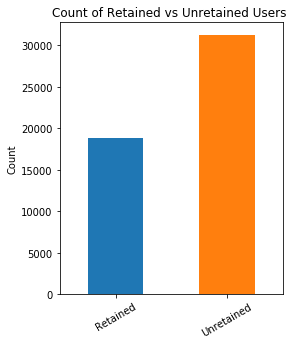

In [10]:
_ = df['retained'].value_counts(ascending=True).plot(kind='bar', figsize=(4,5))
_ = plt.title('Count of Retained vs Unretained Users ')
_ = plt.xticks([0,1], ['Retained', 'Unretained'], rotation=30)
_ = plt.ylabel('Count')
plt.savefig('figures\retained_users.png');

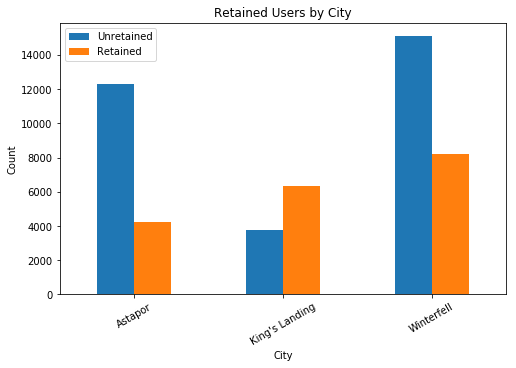

In [11]:
# Explore Feature Colinearity
_ = pd.crosstab(df['city'], df['retained']).plot(kind='bar', figsize=(8,5))
_ = plt.title('Retained Users by City')
_ = plt.xlabel('City')
_ = plt.xticks(rotation=30)
_ = plt.ylabel('Count')
_ = plt.legend(['Unretained', 'Retained'])
plt.savefig('figures\retained_users_by_city.png');

In [12]:
df.groupby(['city']).mean()['retained']

city
Astapor           0.255715
King's Landing    0.628134
Winterfell        0.351945
Name: retained, dtype: float64

- Users coming from King's Landing are more likely to be retained in month 6 than those coming from Astaphor or Winterfell.

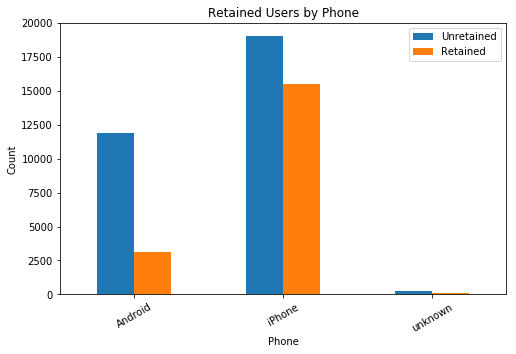

In [13]:
_ = pd.crosstab(df['phone'], df['retained']).plot(kind='bar', figsize=(8,5))
_ = plt.title('Retained Users by Phone')
_ = plt.xlabel('Phone')
_ = plt.xticks(rotation=30)
_ = plt.ylabel('Count')
_ = plt.legend(['Unretained', 'Retained'])
plt.savefig('figures\retained_users_by_phone.png');

In [14]:
df.groupby(['phone']).mean()['retained']

phone
Android    0.209426
iPhone     0.448933
unknown    0.335859
Name: retained, dtype: float64

- Users using an iPhone are more likely to be retained in month 6 than those using Androids or unknown devices.

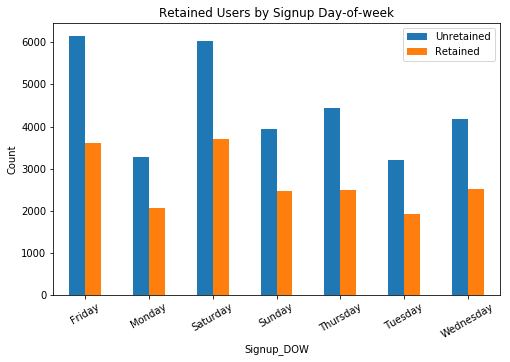

In [15]:
_ = pd.crosstab(df['signup_dow'], df['retained']).plot(kind='bar', figsize=(8,5))
_ = plt.title('Retained Users by Signup Day-of-week')
_ = plt.xlabel('Signup_DOW')
_ = plt.xticks(rotation=30)
_ = plt.ylabel('Count')
_ = plt.legend(['Unretained', 'Retained'])
plt.savefig('figures\retained_users_by_signup_dow.png');

In [16]:
df.groupby(['signup_dow']).mean()['retained']

signup_dow
Friday       0.370533
Monday       0.387984
Saturday     0.380453
Sunday       0.384687
Thursday     0.360115
Tuesday      0.376073
Wednesday    0.376645
Name: retained, dtype: float64

- Signup day-of-week does not appear to be a strong predictor for whether or not a user will be retained in month 6.

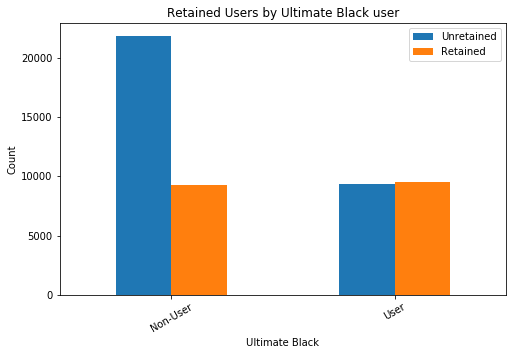

In [17]:
_ = pd.crosstab(df['ultimate_black_user'], df['retained']).plot(kind='bar', figsize=(8,5))
_ = plt.title('Retained Users by Ultimate Black user')
_ = plt.xlabel('Ultimate Black')
_ = plt.xticks([0,1], ['Non-User', 'User'], rotation=30)
_ = plt.ylabel('Count')
_ = plt.legend(['Unretained', 'Retained'])
plt.savefig('figures\retained_users_by_ultimate_black.png');

In [18]:
df.groupby(['ultimate_black_user']).mean()['retained']

ultimate_black_user
False    0.298818
True     0.503713
Name: retained, dtype: float64

- Users who use Ultimate Black in their first 30 days are more likely to be retained in their 6th month than those who did not use Ultimate Black in their first 30 days. 

** Prediction **

Since the classes are imbalanced and the predictive variables are both categorical and numerical, I will use a tree-based method. I select the random forest since it does well with large number of features, feature importances can be extracted, and it is less prone to overfitting than a decision tree.

In [19]:
# Set categoricals to dummy variables
df_with_dummies = pd.get_dummies(df, columns=['city', 'phone', 'signup_dow', 'ultimate_black_user'], drop_first=True)

In [20]:
# Define target and predictive variables
y = df['retained']

# Drop last_trip_date and from X because it is not informative for determining in advance whether a user will retain. 
X = df_with_dummies.drop(['last_trip_date', 'retained'], axis=1)

In [21]:
# Scale the data
Xscaled = scale(X)

# Train-test split (70%-30%)
Xtrain, Xtest, ytrain, ytest = train_test_split(Xscaled, y, train_size=0.7, random_state=42)

/Users/Tami/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [22]:
# Build classifier
rfc = RandomForestClassifier(random_state=42)
# Train
rfc.fit(Xtrain, ytrain)
# Predict
ypred = rfc.predict(Xtest)

# Calculate performance Metrics
# print('Random Forest predicts on unseen data with', (
print('Accuracy:', accuracy_score(ytest, ypred))
# )*100, '% accuracy.' )
print('Precision:', precision_score(ytest, ypred))
print('Recall:', recall_score(ytest, ypred))
print('Confusion Matrix:')
print(confusion_matrix(ytest, ypred))
print('Classification Report:')
print(classification_report(ytest, ypred))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

Accuracy: 0.7516
Precision: 0.69918015556
Recall: 0.591709660203
Confusion Matrix:
[[7948 1431]
 [2295 3326]]
Classification Report:
             precision    recall  f1-score   support

      False       0.78      0.85      0.81      9379
       True       0.70      0.59      0.64      5621

avg / total       0.75      0.75      0.75     15000



- The model predicts which users will be retained in their 6th month on the system with 75% accuracy.
- 70% of the users the model predicts will be retained are in fact retained.
- 59% of the users that are retained are captured by the model. 
- 78% of the users the model predicts will not be retained are in fact lost.
- 85% of the users that are lost are captured by the model. Thus the model will provide useful information for the "customer-retention" team at Ultimate. It will tell the team which users they should target for increased marketing efforts aimed at retention.

In [23]:
# Collect the feature_importances_ in a dataframe
imp_feats = pd.DataFrame({'features':np.array(X.columns), 'importance':rfc.feature_importances_})
imp_feats.sort_values('importance', ascending=False, inplace=True)
imp_feats.head(10)

,features,importance
0,avg_dist,0.238231
6,weekday_pct,0.132028
1,avg_rating_by_driver,0.114553
4,surge_pct,0.085262
2,avg_rating_of_driver,0.081150
5,trips_in_first_30_days,0.077908
7,city_King's Landing,0.060326
3,avg_surge,0.052083
9,phone_iPhone,0.035377
17,ultimate_black_user_True,0.032464


** Results**

The most important factors for determining whether a user will be retained are: **`avg_dist`, `weekday_pct`, `avg_rating_by_driver`**, **`surge_pct`** and **`avg_rating_of_driver`.** 


To improve its long-term rider retention, my advice to Ultimate is as follows:
1. Focus marketing attention on users who travel a long average distance in their first 30 days, take the majority of their trips during the weekdays, take the majority of their trips during surge pricing, and/or are given low ratings by drivers.
2. Consider offering **occassional reductions to surge pricing for very active users**. One example might be to offer a no-surge coupon to users after their 5th trip, or after their 5th month of activity. 
3. Invest in **training for drivers,** and **incentivize drivers to seek high ratings**. 

